In [10]:
from ASDM.ASDM import Structure
from ASDM.Utilities import plot_time_series
import pandas as pd
import plotly.express as px
pd.options.display.max_columns = 100

# First we re-create the model manually

In [26]:
class PatientFlow(Structure):
    def __init__(self):
        super(PatientFlow, self).__init__()
        self.add_stock("Waiting_list", 100, in_flows=['GP_referrals'], out_flows=['Hospital_admission_rate'])
        self.add_stock("In_hospital", 30, in_flows=['Hospital_admission_rate'], out_flows=['Treatment_completion_rate'])
        self.add_stock("In_community_care", 100, in_flows=['Treatment_completion_rate'], out_flows=['Community_care_leaving_rate'])
        
        self.add_aux("Hospital_bed_capacity", 30)
        self.add_aux("Hospital_bed_vacancy", "Hospital_bed_capacity-In_hospital")
        self.add_aux("p_completion", 0.1)
        self.add_aux("p_leaving", 0.1)

        self.add_flow("GP_referrals", 3)
        self.add_flow(
            "Hospital_admission_rate", 
            "MIN(Waiting_list, MAX(Treatment_completion_rate, Hospital_bed_vacancy))",  # mimicing the non-negative stock behaviour
            )
        self.add_flow(
            "Treatment_completion_rate", 
            "RBINOM(In_hospital, p_completion)", 
            )
        self.add_flow(
            "Community_care_leaving_rate", 
            "RBINOM(In_community_care, p_leaving)", 
            )

        # mapping SD functions to Python functions
        self.custom_functions['MAX'] = max
        self.custom_functions['MIN'] = min


In [27]:
# Model Object Created

patient_flow_model = PatientFlow()
patient_flow_model.clear_last_run()
patient_flow_model.simulate(time=20, dt=1)
df_patient_flow = patient_flow_model.export_simulation_result()
df_patient_flow['In_hospital']

[30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0]

In [31]:
# To turn it into a dataframe (if needed)

dataframe = pd.DataFrame(df_patient_flow)
dataframe.head()

,Waiting_list,GP_referrals,In_hospital,p_completion,Treatment_completion_rate,Hospital_bed_capacity,Hospital_bed_vacancy,Hospital_admission_rate,In_community_care,p_leaving,Community_care_leaving_rate,Weeks
0,100.00,3.0,30.0,0.1,3.0,30.0,0.0,3.0,100.00,0.1,15.0,0
1,100.00,3.0,30.0,0.1,3.0,30.0,0.0,3.0,97.00,0.1,15.0,1
2,100.00,3.0,30.0,0.1,6.0,30.0,0.0,6.0,94.00,0.1,10.0,2
3,99.25,3.0,30.0,0.1,6.0,30.0,0.0,6.0,93.00,0.1,9.0,3
4,98.50,3.0,30.0,0.1,4.0,30.0,0.0,4.0,92.25,0.1,14.0,4


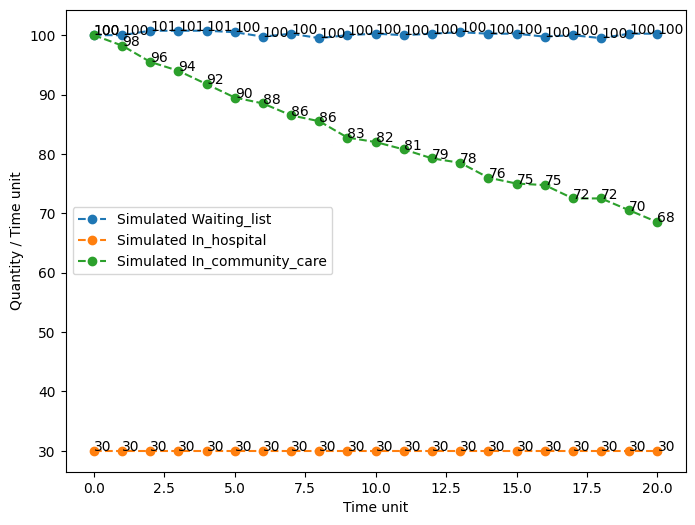

In [4]:
# Time Series Plotting

plot_time_series({
    "Waiting_list": {"Simulated": df_patient_flow['Waiting_list']},
    "In_hospital": {"Simulated": df_patient_flow['In_hospital']},
    "In_community_care": {"Simulated": df_patient_flow['In_community_care']}
    }, separate_ax=False)

# Now Compiled from Source

In [5]:
# Now with compiled model
# Compile the model from XMILE

model = Structure(from_xmile='Elective Recovery Model.stmx')

ENGINE Reading XMILE model from Elective Recovery Model.stmx


In [6]:
# Clearing the last run and compiling exporting the result

model.clear_last_run()
model.simulate()
results = model.export_simulation_result()

In [7]:
# Here are the keys

results.keys()

dict_keys(['Recognised_need_for_GP_consultation', 'Expected_population_rate_of_incidence_pw', 'Underlying_trend_in_health_needs', 'Switch_for_demographic_increase', 'Incidence_of_condition', 'Percent_people_not_presenting_during_COVID', 'COVID_period', 'COVID_switch', 'Decision_not_to_present', 'Need_presenting_as_usual', 'Holding_stock_of_potential_unmet_need', 'Holding_stock_released_at_end_of_COVID', 'Outcome_of_consultation', 'Percent_of_need_referred_for_diagnostics', 'NFA_following_initial_consultation', 'Proceeding_to_tests_without_COVID_delay', 'Average_pre_COVID_wait_for_diagnostics', 'Waiting_for_diagnostics', 'Period_of_return_in_wks', 'Percent_of_unmet_need_returning', 'Depleting_stock_of_unmet_need', 'COVID_delayed_need_presenting', 'Delayed_need_not_presenting', 'Increased_percent_of_need_for_diagnostics_for_COVID_delayed_demand', 'Delayed_demand_to_wait_for_diagnostics', 'Pre_COVID_capacity_for_diagnostics', 'Reduced_diagnostic_capacity_during_COVID', 'Percent_increase_i

### Plot ASDM simulation DataFrame

In [25]:
df = pd.DataFrame(results)
# df['Average_wait_for_diagnostic_test'] = pd.to_datetime(df['Average_wait_for_diagnostic_test'])  # Convert the 'time' column to datetime objects

# Now specify the columns directly
fig = px.line(df, x='Weeks', y=["Waiting_more_than_12mths", "Waiting_6_to_12mths_for_treatment", "Waiting_12_to_24mths_for_treatment"])

fig.update_layout(
    title='Treatment Waiting Times',
    xaxis_title='Weeks',
    yaxis_title='Number of Patients',
    legend_title='Waiting Period',
)

fig.show()